# Dependencies

In [1]:
!curl -L "https://github.com/OutofAi/tiny-cuda-nn-wheels/releases/download/Kaggle-T4/tinycudann-1.7-cp310-cp310-linux_x86_64.whl" -o tinycudann-1.7-cp310-cp310-linux_x86_64.whl
!python -m pip install tinycudann-1.7-cp310-cp310-linux_x86_64.whl --force-reinstall --no-cache-dir

!pip install trimesh
!pip install torch-ema
!pip install PyMCubes
!pip install pyglet
!pip install imageio[ffmpeg]

!git clone https://github.com/tri154/ray_marching_binding.git temp_repo  
!mv temp_repo/raymarching .
!rm -rf temp_repo
%cd raymarching
!python setup.py build_ext --inplace # build ext only, do not install (only can be used in the parent directory)
!pip install .
%cd /kaggle/working/
import raymarching

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.4M  100 25.4M    0     0  63.6M      0 --:--:-- --:--:-- --:--:-- 63.6M
Processing ./tinycudann-1.7-cp310-cp310-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 12.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 6.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 945.1/945.1 kB 14.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 68.8 MB/s eta 0:00:00:00:0100:01
Cloning into 'temp_repo'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 2), reused 15 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (15/15), 11.30 

# IMPORT

In [5]:
import raymarching
import tinycudann as tcnn
import trimesh
import torch 
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch import nn
import numpy as np
import os
import cv2
import glob
import json
from cv2 import transform
from scipy.spatial.transform import Slerp, Rotation
import tqdm
from torch.utils.data import DataLoader

import math
from torch_ema import ExponentialMovingAverage
import time
import mcubes
from rich.console import Console
from torch.cuda.amp import custom_bwd, custom_fwd
import matplotlib.pyplot as plt

class _trunc_exp(torch.autograd.Function):
    @staticmethod
    @custom_fwd(cast_inputs=torch.float32)
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.exp(x)

    @staticmethod
    @custom_bwd
    def backward(ctx, g):
        x = ctx.saved_tensors[0]
        return g * torch.exp(x.clamp(-15, 15))


trunc_exp = _trunc_exp.apply

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CONFIG

In [6]:
class Config:
    def __init__(self):
        self.path = "/kaggle/input/nerf-synthetic-dataset/nerf_synthetic/lego"
        self.workspace = 'custom_nerf'
        self.preload = True
        self.dt_gamma = 0 #default
        self.scale = 0.33 #Default 0.33
        self.bound = 1 #Default 1
        self.offset = [0, 0, 0]
        self.fp16 = True
        self.rand_pose = -1 # <0 : off.
        self.num_rays = 4096 
        self.error_map = False
        self.color_space = 'srgb'
        self.cuda_ray = True
        self.preload = True
        self.min_near = 0.2
        self.density_thresh = 10
        self.bg_radius = -1
        self.update_extra_interval = 16
        self.lr = 0.01
        self.iters = 300 * 100
        self.patch_size = 1
        self.density_scale = 1
opt = Config()

# **Model**

In [7]:
def sample_pdf(bins, weights, n_samples, det=False):
    # This implementation is from NeRF
    # bins: [B, T], old_z_vals
    # weights: [B, T - 1], bin weights.
    # return: [B, n_samples], new_z_vals

    # Get pdf
    weights = weights + 1e-5  # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)
    # Take uniform samples
    if det:
        u = torch.linspace(0. + 0.5 / n_samples, 1. - 0.5 / n_samples, steps=n_samples).to(weights.device)
        u = u.expand(list(cdf.shape[:-1]) + [n_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [n_samples]).to(weights.device)

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(inds - 1), inds - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (B, n_samples, 2)

    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples


In [8]:
class NeRFNetwork(nn.Module):
    def __init__(
        self,
        opt,
        encoding="HashGrid",
        encoding_dir="SphericalHarmonics",
        num_layers=2,
        hidden_dim=64,
        geo_feat_dim=15,
        num_layers_color=3,
        hidden_dim_color=64,
        bound=1,
        **kwargs,
    ):
        super().__init__()
        self.opt = opt
        self.dt_gamma = opt.dt_gamma
        self.density_scale = opt.density_scale
        self.bound = opt.bound
        self.cuda_ray = opt.cuda_ray
        self.bound = opt.bound
        self.min_near = opt.min_near
        self.density_thresh = opt.density_thresh
        self.bg_radius = opt.bg_radius
        self.cascade = 1 + math.ceil(math.log2(bound))
        self.grid_size = 128
        
        aabb_train = torch.FloatTensor([-bound, -bound, -bound, bound, bound, bound])
        aabb_infer = aabb_train.clone()
        self.register_buffer('aabb_train', aabb_train)
        self.register_buffer('aabb_infer', aabb_infer)
        

        if self.cuda_ray:
            density_grid = torch.zeros([self.cascade, self.grid_size ** 3]) 
            density_bitfield = torch.zeros(self.cascade * self.grid_size ** 3 // 8, dtype=torch.uint8) 
            self.register_buffer('density_grid', density_grid)
            self.register_buffer('density_bitfield', density_bitfield)
            self.mean_density = 0
            self.iter_density = 0
            # step counter
            step_counter = torch.zeros(16, 2, dtype=torch.int32) 
            self.register_buffer('step_counter', step_counter)
            self.mean_count = 0
            self.local_step = 0
        
        # sigma network
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.geo_feat_dim = geo_feat_dim

        per_level_scale = np.exp2(np.log2(2048 * bound / 16) / (16 - 1))

        self.encoder = tcnn.Encoding(
            n_input_dims=3,
            encoding_config={
                "otype": "HashGrid",
                "n_levels": 16,
                "n_features_per_level": 2,
                "log2_hashmap_size": 19,
                "base_resolution": 16,
                "per_level_scale": per_level_scale,
            },
        )

        self.sigma_net = tcnn.Network(
            n_input_dims=32,
            n_output_dims=1 + self.geo_feat_dim,
            network_config={
                "otype": "FullyFusedMLP",
                "activation": "ReLU",
                "output_activation": "None",
                "n_neurons": hidden_dim,
                "n_hidden_layers": num_layers - 1,
            },
        )

        # color network
        self.num_layers_color = num_layers_color
        self.hidden_dim_color = hidden_dim_color

        self.encoder_dir = tcnn.Encoding(
            n_input_dims=3,
            encoding_config={
                "otype": "SphericalHarmonics",
                "degree": 4,
            },
        )

        self.in_dim_color = self.encoder_dir.n_output_dims + self.geo_feat_dim

        self.color_net = tcnn.Network(
            n_input_dims=self.in_dim_color,
            n_output_dims=3,
            network_config={
                "otype": "FullyFusedMLP",
                "activation": "ReLU",
                "output_activation": "None",
                "n_neurons": hidden_dim_color,
                "n_hidden_layers": num_layers_color - 1,
            },
        )


    @torch.no_grad()
    def mark_untrained_grid(self, poses, intrinsic, S=64):
        # poses: [B, 4, 4]
        # intrinsic: [3, 3]

        if not self.cuda_ray:
            return
        
        if isinstance(poses, np.ndarray):
            poses = torch.from_numpy(poses)

        B = poses.shape[0]
        
        fx, fy, cx, cy = intrinsic
        
        X = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)
        Y = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)
        Z = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)

        count = torch.zeros_like(self.density_grid)
        poses = poses.to(count.device)


        for xs in X:
            for ys in Y:
                for zs in Z:
                    
                    # construct points
                    xx, yy, zz = torch.meshgrid(xs, ys, zs, indexing='ij')
                    coords = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)], dim=-1) # [N, 3], in [0, 128)
                    indices = raymarching.morton3D(coords).long() # [N]
                    world_xyzs = (2 * coords.float() / (self.grid_size - 1) - 1).unsqueeze(0) # [1, N, 3] in [-1, 1]

                    # cascading
                    for cas in range(self.cascade):
                        bound = min(2 ** cas, self.bound)
                        half_grid_size = bound / self.grid_size
                        # scale to current cascade's resolution
                        cas_world_xyzs = world_xyzs * (bound - half_grid_size)

                        # split batch to avoid OOM
                        head = 0
                        while head < B:
                            tail = min(head + S, B)

                            # world2cam transform (poses is c2w, so we need to transpose it. Another transpose is needed for batched matmul, so the final form is without transpose.)
                            cam_xyzs = cas_world_xyzs - poses[head:tail, :3, 3].unsqueeze(1)
                            cam_xyzs = cam_xyzs @ poses[head:tail, :3, :3] # [S, N, 3]
                            
                            # query if point is covered by any camera
                            mask_z = cam_xyzs[:, :, 2] > 0 # [S, N]
                            mask_x = torch.abs(cam_xyzs[:, :, 0]) < cx / fx * cam_xyzs[:, :, 2] + half_grid_size * 2
                            mask_y = torch.abs(cam_xyzs[:, :, 1]) < cy / fy * cam_xyzs[:, :, 2] + half_grid_size * 2
                            mask = (mask_z & mask_x & mask_y).sum(0).reshape(-1) # [N]

                            # update count 
                            count[cas, indices] += mask
                            head += S
    
        # mark untrained grid as -1
        self.density_grid[count == 0] = -1

        print(f'[mark untrained grid] {(count == 0).sum()} from {self.grid_size ** 3 * self.cascade}')

    def run(self, rays_o, rays_d, num_steps=128, upsample_steps=128, bg_color=None, perturb=False, **kwargs):
        # rays_o, rays_d: [B, N, 3], assumes B == 1
        # bg_color: [3] in range [0, 1]
        # return: image: [B, N, 3], depth: [B, N]

        prefix = rays_o.shape[:-1]
        rays_o = rays_o.contiguous().view(-1, 3)
        rays_d = rays_d.contiguous().view(-1, 3)

        N = rays_o.shape[0] # N = B * N, in fact
        device = rays_o.device

        # choose aabb
        aabb = self.aabb_train if self.training else self.aabb_infer

        # sample steps
        nears, fars = raymarching.near_far_from_aabb(rays_o, rays_d, aabb, self.min_near)
        nears.unsqueeze_(-1)
        fars.unsqueeze_(-1)

        #print(f'nears = {nears.min().item()} ~ {nears.max().item()}, fars = {fars.min().item()} ~ {fars.max().item()}')

        z_vals = torch.linspace(0.0, 1.0, num_steps, device=device).unsqueeze(0) # [1, T]
        z_vals = z_vals.expand((N, num_steps)) # [N, T]
        z_vals = nears + (fars - nears) * z_vals # [N, T], in [nears, fars]

        # perturb z_vals
        sample_dist = (fars - nears) / num_steps
        if perturb:
            z_vals = z_vals + (torch.rand(z_vals.shape, device=device) - 0.5) * sample_dist
            #z_vals = z_vals.clamp(nears, fars) # avoid out of bounds xyzs.

        # generate xyzs
        xyzs = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2) * z_vals.unsqueeze(-1) # [N, 1, 3] * [N, T, 1] -> [N, T, 3]
        xyzs = torch.min(torch.max(xyzs, aabb[:3]), aabb[3:]) # a manual clip.

        #plot_pointcloud(xyzs.reshape(-1, 3).detach().cpu().numpy())

        # query SDF and RGB
        density_outputs = self.density(xyzs.reshape(-1, 3))

        #sigmas = density_outputs['sigma'].view(N, num_steps) # [N, T]
        for k, v in density_outputs.items():
            density_outputs[k] = v.view(N, num_steps, -1)

        # upsample z_vals (nerf-like)
        if upsample_steps > 0:
            with torch.no_grad():

                deltas = z_vals[..., 1:] - z_vals[..., :-1] # [N, T-1]
                deltas = torch.cat([deltas, sample_dist * torch.ones_like(deltas[..., :1])], dim=-1)

                alphas = 1 - torch.exp(-deltas * self.density_scale * density_outputs['sigma'].squeeze(-1)) # [N, T]
                alphas_shifted = torch.cat([torch.ones_like(alphas[..., :1]), 1 - alphas + 1e-15], dim=-1) # [N, T+1]
                weights = alphas * torch.cumprod(alphas_shifted, dim=-1)[..., :-1] # [N, T]

                # sample new z_vals
                z_vals_mid = (z_vals[..., :-1] + 0.5 * deltas[..., :-1]) # [N, T-1]
                new_z_vals = sample_pdf(z_vals_mid, weights[:, 1:-1], upsample_steps, det=not self.training).detach() # [N, t]

                new_xyzs = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2) * new_z_vals.unsqueeze(-1) # [N, 1, 3] * [N, t, 1] -> [N, t, 3]
                new_xyzs = torch.min(torch.max(new_xyzs, aabb[:3]), aabb[3:]) # a manual clip.

            # only forward new points to save computation
            new_density_outputs = self.density(new_xyzs.reshape(-1, 3))
            #new_sigmas = new_density_outputs['sigma'].view(N, upsample_steps) # [N, t]
            for k, v in new_density_outputs.items():
                new_density_outputs[k] = v.view(N, upsample_steps, -1)

            # re-order
            z_vals = torch.cat([z_vals, new_z_vals], dim=1) # [N, T+t]
            z_vals, z_index = torch.sort(z_vals, dim=1)

            xyzs = torch.cat([xyzs, new_xyzs], dim=1) # [N, T+t, 3]
            xyzs = torch.gather(xyzs, dim=1, index=z_index.unsqueeze(-1).expand_as(xyzs))

            for k in density_outputs:
                tmp_output = torch.cat([density_outputs[k], new_density_outputs[k]], dim=1)
                density_outputs[k] = torch.gather(tmp_output, dim=1, index=z_index.unsqueeze(-1).expand_as(tmp_output))

        deltas = z_vals[..., 1:] - z_vals[..., :-1] # [N, T+t-1]
        deltas = torch.cat([deltas, sample_dist * torch.ones_like(deltas[..., :1])], dim=-1)
        alphas = 1 - torch.exp(-deltas * self.density_scale * density_outputs['sigma'].squeeze(-1)) # [N, T+t]
        alphas_shifted = torch.cat([torch.ones_like(alphas[..., :1]), 1 - alphas + 1e-15], dim=-1) # [N, T+t+1]
        weights = alphas * torch.cumprod(alphas_shifted, dim=-1)[..., :-1] # [N, T+t]

        dirs = rays_d.view(-1, 1, 3).expand_as(xyzs)
        for k, v in density_outputs.items():
            density_outputs[k] = v.view(-1, v.shape[-1])

        mask = weights > 1e-4 # hard coded
        rgbs = self.color(xyzs.reshape(-1, 3), dirs.reshape(-1, 3), mask=mask.reshape(-1), **density_outputs)
        rgbs = rgbs.view(N, -1, 3) # [N, T+t, 3]

        #print(xyzs.shape, 'valid_rgb:', mask.sum().item())

        # calculate weight_sum (mask)
        weights_sum = weights.sum(dim=-1) # [N]
        
        # calculate depth 
        ori_z_vals = ((z_vals - nears) / (fars - nears)).clamp(0, 1)
        depth = torch.sum(weights * ori_z_vals, dim=-1)

        # calculate color
        image = torch.sum(weights.unsqueeze(-1) * rgbs, dim=-2) # [N, 3], in [0, 1]

        # mix background color
        if self.bg_radius > 0:
            # use the bg model to calculate bg_color
            sph = raymarching.sph_from_ray(rays_o, rays_d, self.bg_radius) # [N, 2] in [-1, 1]
            bg_color = self.background(sph, rays_d.reshape(-1, 3)) # [N, 3]
        elif bg_color is None:
            bg_color = 1
            
        image = image + (1 - weights_sum).unsqueeze(-1) * bg_color

        image = image.view(*prefix, 3)
        depth = depth.view(*prefix)

        # tmp: reg loss in mip-nerf 360
        # z_vals_shifted = torch.cat([z_vals[..., 1:], sample_dist * torch.ones_like(z_vals[..., :1])], dim=-1)
        # mid_zs = (z_vals + z_vals_shifted) / 2 # [N, T]
        # loss_dist = (torch.abs(mid_zs.unsqueeze(1) - mid_zs.unsqueeze(2)) * (weights.unsqueeze(1) * weights.unsqueeze(2))).sum() + 1/3 * ((z_vals_shifted - z_vals_shifted) * (weights ** 2)).sum()

        return {
            'depth': depth,
            'image': image,
            'weights_sum': weights_sum,
        }

    
    def run_cuda(self, rays_o, rays_d, dt_gamma=0, bg_color=None, perturb=False, force_all_rays=False, max_steps=1024, T_thresh=1e-4, **kwargs):
        # rays_o, rays_d: [B, N, 3], assumes B == 1
        # return: image: [B, N, 3], depth: [B, N]

        prefix = rays_o.shape[:-1]
        rays_o = rays_o.contiguous().view(-1, 3)
        rays_d = rays_d.contiguous().view(-1, 3)

        N = rays_o.shape[0] # N = B * N, in fact
        device = rays_o.device

        # pre-calculate near far
        nears, fars = raymarching.near_far_from_aabb(rays_o, rays_d, self.aabb_train if self.training else self.aabb_infer, self.min_near)

        # mix background color
        if self.bg_radius > 0:
            # use the bg model to calculate bg_color
            sph = raymarching.sph_from_ray(rays_o, rays_d, self.bg_radius) # [N, 2] in [-1, 1]
            bg_color = self.background(sph, rays_d) # [N, 3]
        elif bg_color is None:
            bg_color = 1

        results = {}

        if self.training:
            # setup counter
            counter = self.step_counter[self.local_step % 16]
            counter.zero_() # set to 0
            self.local_step += 1

            xyzs, dirs, deltas, rays = raymarching.march_rays_train(rays_o, rays_d, self.bound, self.density_bitfield, self.cascade, self.grid_size, nears, fars, counter, self.mean_count, perturb, 128, force_all_rays, dt_gamma, max_steps)

            #plot_pointcloud(xyzs.reshape(-1, 3).detach().cpu().numpy())
            
            sigmas, rgbs = self(xyzs, dirs)
            # density_outputs = self.density(xyzs) # [M,], use a dict since it may include extra things, like geo_feat for rgb.
            # sigmas = density_outputs['sigma']
            # rgbs = self.color(xyzs, dirs, **density_outputs)
            sigmas = self.density_scale * sigmas

            #print(f'valid RGB query ratio: {mask.sum().item() / mask.shape[0]} (total = {mask.sum().item()})')

            # special case for CCNeRF's residual learning
            if len(sigmas.shape) == 2:
                K = sigmas.shape[0]
                depths = []
                images = []
                for k in range(K):
                    weights_sum, depth, image = raymarching.composite_rays_train(sigmas[k], rgbs[k], deltas, rays, T_thresh)
                    image = image + (1 - weights_sum).unsqueeze(-1) * bg_color
                    depth = torch.clamp(depth - nears, min=0) / (fars - nears)
                    images.append(image.view(*prefix, 3))
                    depths.append(depth.view(*prefix))
            
                depth = torch.stack(depths, axis=0) # [K, B, N]
                image = torch.stack(images, axis=0) # [K, B, N, 3]

            else:

                weights_sum, depth, image = raymarching.composite_rays_train(sigmas, rgbs, deltas, rays, T_thresh)
                image = image + (1 - weights_sum).unsqueeze(-1) * bg_color
                depth = torch.clamp(depth - nears, min=0) / (fars - nears)
                image = image.view(*prefix, 3)
                depth = depth.view(*prefix)
            
            results['weights_sum'] = weights_sum

        else:
           
            # allocate outputs 
            # if use autocast, must init as half so it won't be autocasted and lose reference.
            #dtype = torch.half if torch.is_autocast_enabled() else torch.float32
            # output should always be float32! only network inference uses half.
            dtype = torch.float32
            
            weights_sum = torch.zeros(N, dtype=dtype, device=device)
            depth = torch.zeros(N, dtype=dtype, device=device)
            image = torch.zeros(N, 3, dtype=dtype, device=device)
            
            n_alive = N
            rays_alive = torch.arange(n_alive, dtype=torch.int32, device=device) # [N]
            rays_t = nears.clone() # [N]

            step = 0
            
            while step < max_steps:

                # count alive rays 
                n_alive = rays_alive.shape[0]
                
                # exit loop
                if n_alive <= 0:
                    break

                # decide compact_steps
                n_step = max(min(N // n_alive, 8), 1)

                xyzs, dirs, deltas = raymarching.march_rays(n_alive, n_step, rays_alive, rays_t, rays_o, rays_d, self.bound, self.density_bitfield, self.cascade, self.grid_size, nears, fars, 128, perturb if step == 0 else False, dt_gamma, max_steps)

                sigmas, rgbs = self(xyzs, dirs)
                # density_outputs = self.density(xyzs) # [M,], use a dict since it may include extra things, like geo_feat for rgb.
                # sigmas = density_outputs['sigma']
                # rgbs = self.color(xyzs, dirs, **density_outputs)
                sigmas = self.density_scale * sigmas

                raymarching.composite_rays(n_alive, n_step, rays_alive, rays_t, sigmas, rgbs, deltas, weights_sum, depth, image, T_thresh)

                rays_alive = rays_alive[rays_alive >= 0]

                #print(f'step = {step}, n_step = {n_step}, n_alive = {n_alive}, xyzs: {xyzs.shape}')

                step += n_step

            image = image + (1 - weights_sum).unsqueeze(-1) * bg_color
            depth = torch.clamp(depth - nears, min=0) / (fars - nears)
            image = image.view(*prefix, 3)
            depth = depth.view(*prefix)
        
        results['depth'] = depth
        results['image'] = image

        return results
    

    
    @torch.no_grad()
    def update_extra_state(self, decay=0.95, S=128):
        # call before each epoch to update extra states.

        if not self.cuda_ray:
            return 
        
        ### update density grid

        tmp_grid = - torch.ones_like(self.density_grid)
        
        # full update.
        if self.iter_density < 16:
        #if True:
            X = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)
            Y = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)
            Z = torch.arange(self.grid_size, dtype=torch.int32, device=self.density_bitfield.device).split(S)

            for xs in X:
                for ys in Y:
                    for zs in Z:
                        
                        # construct points
                        # xx, yy, zz = custom_meshgrid(xs, ys, zs)
                        xx, yy, zz = torch.meshgrid(xs, ys, zs, indexing='ij')
                        coords = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)], dim=-1) # [N, 3], in [0, 128)
                        indices = raymarching.morton3D(coords).long() # [N]
                        xyzs = 2 * coords.float() / (self.grid_size - 1) - 1 # [N, 3] in [-1, 1]

                        # cascading
                        for cas in range(self.cascade):
                            bound = min(2 ** cas, self.bound)
                            half_grid_size = bound / self.grid_size
                            # scale to current cascade's resolution
                            cas_xyzs = xyzs * (bound - half_grid_size)
                            # add noise in [-hgs, hgs]
                            cas_xyzs += (torch.rand_like(cas_xyzs) * 2 - 1) * half_grid_size
                            # query density
                            sigmas = self.density(cas_xyzs)['sigma'].reshape(-1).detach()
                            sigmas *= self.density_scale
                            # assign 
                            tmp_grid[cas, indices] = sigmas

        # partial update (half the computation)
        # TODO: why no need of maxpool ?
        else:
            N = self.grid_size ** 3 // 4 # H * H * H / 4
            for cas in range(self.cascade):
                # random sample some positions
                coords = torch.randint(0, self.grid_size, (N, 3), device=self.density_bitfield.device) # [N, 3], in [0, 128)
                indices = raymarching.morton3D(coords).long() # [N]
                # random sample occupied positions
                occ_indices = torch.nonzero(self.density_grid[cas] > 0).squeeze(-1) # [Nz]
                rand_mask = torch.randint(0, occ_indices.shape[0], [N], dtype=torch.long, device=self.density_bitfield.device)
                occ_indices = occ_indices[rand_mask] # [Nz] --> [N], allow for duplication
                occ_coords = raymarching.morton3D_invert(occ_indices) # [N, 3]
                # concat
                indices = torch.cat([indices, occ_indices], dim=0)
                coords = torch.cat([coords, occ_coords], dim=0)
                # same below
                xyzs = 2 * coords.float() / (self.grid_size - 1) - 1 # [N, 3] in [-1, 1]
                bound = min(2 ** cas, self.bound)
                half_grid_size = bound / self.grid_size
                # scale to current cascade's resolution
                cas_xyzs = xyzs * (bound - half_grid_size)
                # add noise in [-hgs, hgs]
                cas_xyzs += (torch.rand_like(cas_xyzs) * 2 - 1) * half_grid_size
                # query density
                sigmas = self.density(cas_xyzs)['sigma'].reshape(-1).detach()
                sigmas *= self.density_scale
                # assign 
                tmp_grid[cas, indices] = sigmas

        ## max-pool on tmp_grid for less aggressive culling [No significant improvement...]
        # invalid_mask = tmp_grid < 0
        # tmp_grid = F.max_pool3d(tmp_grid.view(self.cascade, 1, self.grid_size, self.grid_size, self.grid_size), kernel_size=3, stride=1, padding=1).view(self.cascade, -1)
        # tmp_grid[invalid_mask] = -1

        # ema update
        valid_mask = (self.density_grid >= 0) & (tmp_grid >= 0)
        self.density_grid[valid_mask] = torch.maximum(self.density_grid[valid_mask] * decay, tmp_grid[valid_mask])
        self.mean_density = torch.mean(self.density_grid.clamp(min=0)).item() # -1 regions are viewed as 0 density.
        #self.mean_density = torch.mean(self.density_grid[self.density_grid > 0]).item() # do not count -1 regions
        self.iter_density += 1

        # convert to bitfield
        density_thresh = min(self.mean_density, self.density_thresh)
        self.density_bitfield = raymarching.packbits(self.density_grid, density_thresh, self.density_bitfield)

        ### update step counter
        total_step = min(16, self.local_step)
        if total_step > 0:
            self.mean_count = int(self.step_counter[:total_step, 0].sum().item() / total_step)
        self.local_step = 0

        #print(f'[density grid] min={self.density_grid.min().item():.4f}, max={self.density_grid.max().item():.4f}, mean={self.mean_density:.4f}, occ_rate={(self.density_grid > 0.01).sum() / (128**3 * self.cascade):.3f} | [step counter] mean={self.mean_count}')


    def render(self, rays_o, rays_d, staged=False, max_ray_batch=4096, **kwargs):
        # rays_o, rays_d: [B, N, 3], assumes B == 1
        # return: pred_rgb: [B, N, 3]

        if self.cuda_ray:
            _run = self.run_cuda
        else:
            _run = self.run

        B, N = rays_o.shape[:2]
        device = rays_o.device

        # never stage when cuda_ray
        if staged and not self.cuda_ray:
            depth = torch.empty((B, N), device=device)
            image = torch.empty((B, N, 3), device=device)

            for b in range(B):
                head = 0
                while head < N:
                    tail = min(head + max_ray_batch, N)
                    results_ = _run(rays_o[b:b+1, head:tail], rays_d[b:b+1, head:tail], **kwargs)
                    depth[b:b+1, head:tail] = results_['depth']
                    image[b:b+1, head:tail] = results_['image']
                    head += max_ray_batch
            
            results = {}
            results['depth'] = depth
            results['image'] = image

        else:
            results = _run(rays_o, rays_d, **kwargs)

        return results
    
    def forward(self, x, d):
        # x: [N, 3], in [-bound, bound]
        # d: [N, 3], nomalized in [-1, 1]

        # sigma
        x = (x + self.bound) / (2 * self.bound)  # to [0, 1]
        x = self.encoder(x)
        h = self.sigma_net(x)

        # sigma = F.relu(h[..., 0])
        sigma = trunc_exp(h[..., 0])
        geo_feat = h[..., 1:]

        # color
        d = (d + 1) / 2  # tcnn SH encoding requires inputs to be in [0, 1]
        d = self.encoder_dir(d)

        # p = torch.zeros_like(geo_feat[..., :1]) # manual input padding
        h = torch.cat([d, geo_feat], dim=-1)
        h = self.color_net(h)

        # sigmoid activation for rgb
        color = torch.sigmoid(h)

        return sigma, color

    def density(self, x):
        # x: [N, 3], in [-bound, bound]

        # sigma
        x = (x + self.bound) / (2 * self.bound)  # to [0, 1]
        x = self.encoder(x)
        h = self.sigma_net(x)

        # sigma = F.relu(h[..., 0])
        sigma = trunc_exp(h[..., 0])
        geo_feat = h[..., 1:]

        return {
            'sigma': sigma,
            'geo_feat': geo_feat
        }

    def color(self, d, mask=None, geo_feat=None, **kwargs):
        # x: [N, 3] in [-bound, bound]
        # mask: [N,], bool, indicates where we actually needs to compute rgb.

        if mask is not None:
            rgbs = torch.zeros(
                mask.shape[0], 3, dtype=geo_feat.dtype, device=geo_feat.device
            )  # [N, 3]
            # in case of empty mask
            if not mask.any():
                return rgbs
            d = d[mask]
            geo_feat = geo_feat[mask]

        # color
        d = (d + 1) / 2  # tcnn SH encoding requires inputs to be in [0, 1]
        d = self.encoder_dir(d)

        h = torch.cat([d, geo_feat], dim=-1)
        h = self.color_net(h)

        # sigmoid activation for rgb
        h = torch.sigmoid(h)

        if mask is not None:
            rgbs[mask] = h.to(rgbs.dtype)  # fp16 --> fp32
        else:
            rgbs = h

        return rgbs

    # optimizer utils
    def get_params(self, lr):
        params = [
            {"params": self.encoder.parameters(), "lr": lr},
            {"params": self.sigma_net.parameters(), "lr": lr},
            {"params": self.encoder_dir.parameters(), "lr": lr},
            {"params": self.color_net.parameters(), "lr": lr},
        ]
        # if self.bg_radius > 0:
        #     params.append({"params": self.encoder_bg.parameters(), "lr": lr})
        #     params.append({"params": self.bg_net.parameters(), "lr": lr})

        return params

In [ ]:
# TEST
# model = NeRFNetwork()
# print(model)

# paras = model.parameters()

# i = 0
# for para in paras:
#     print(para)
# for para in model.encoder.parameters():
#     print(para)
# for para in model.sigma_net.parameters():
#     print(para)
# for para in model.encoder_dir.parameters():
#     print(para)
# for para in model.color_net.parameters():
#     print(para)




# DATA

## Utils function

In [9]:
@torch.cuda.amp.autocast(enabled=False)
def get_rays(poses, intrinsics, H, W, N=-1, error_map=None, patch_size=1):
    ''' get rays
    Args:
        poses: [B, 4, 4], cam2world
        intrinsics: [4]
        H, W, N: int
        error_map: [B, 128 * 128], sample probability based on training error
    Returns:
        rays_o, rays_d: [B, N, 3]
        inds: [B, N]
    '''

    device = poses.device
    B = poses.shape[0]
    fx, fy, cx, cy = intrinsics

    i, j = torch.meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device), indexing='ij')
    # i, j = custom_meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device)) # float
    i = i.t().reshape([1, H*W]).expand([B, H*W]) + 0.5
    j = j.t().reshape([1, H*W]).expand([B, H*W]) + 0.5

    results = {}

    if N > 0:
        N = min(N, H*W)

        # if use patch-based sampling, ignore error_map
        if patch_size > 1:

            # random sample left-top cores.
            # NOTE: this impl will lead to less sampling on the image corner pixels... but I don't have other ideas.
            num_patch = N // (patch_size ** 2)
            inds_x = torch.randint(0, H - patch_size, size=[num_patch], device=device)
            inds_y = torch.randint(0, W - patch_size, size=[num_patch], device=device)
            inds = torch.stack([inds_x, inds_y], dim=-1) # [np, 2]

            # create meshgrid for each patch
            pi, pj = torch.meshgrid(torch.arange(patch_size, device=device), torch.arange(patch_size, device=device), indexing='ij')
            # pi, pj = custom_meshgrid(torch.arange(patch_size, device=device), torch.arange(patch_size, device=device))
            offsets = torch.stack([pi.reshape(-1), pj.reshape(-1)], dim=-1) # [p^2, 2]

            inds = inds.unsqueeze(1) + offsets.unsqueeze(0) # [np, p^2, 2]
            inds = inds.view(-1, 2) # [N, 2]
            inds = inds[:, 0] * W + inds[:, 1] # [N], flatten

            inds = inds.expand([B, N])

        elif error_map is None:
            inds = torch.randint(0, H*W, size=[N], device=device) # may duplicate
            inds = inds.expand([B, N])
        else:

            # weighted sample on a low-reso grid
            inds_coarse = torch.multinomial(error_map.to(device), N, replacement=False) # [B, N], but in [0, 128*128)

            # map to the original resolution with random perturb.
            inds_x, inds_y = inds_coarse // 128, inds_coarse % 128 # `//` will throw a warning in torch 1.10... anyway.
            sx, sy = H / 128, W / 128
            inds_x = (inds_x * sx + torch.rand(B, N, device=device) * sx).long().clamp(max=H - 1)
            inds_y = (inds_y * sy + torch.rand(B, N, device=device) * sy).long().clamp(max=W - 1)
            inds = inds_x * W + inds_y

            results['inds_coarse'] = inds_coarse # need this when updating error_map

        i = torch.gather(i, -1, inds)
        j = torch.gather(j, -1, inds)

        results['inds'] = inds

    else:
        inds = torch.arange(H*W, device=device).expand([B, H*W])

    zs = torch.ones_like(i)
    xs = (i - cx) / fx * zs
    ys = (j - cy) / fy * zs
    directions = torch.stack((xs, ys, zs), dim=-1)
    directions = directions / torch.norm(directions, dim=-1, keepdim=True)
    rays_d = directions @ poses[:, :3, :3].transpose(-1, -2) # (B, N, 3)

    rays_o = poses[..., :3, 3] # [B, 3]
    rays_o = rays_o[..., None, :].expand_as(rays_d) # [B, N, 3]

    results['rays_o'] = rays_o
    results['rays_d'] = rays_d

    return results

def nerf_matrix_to_ngp(pose, scale=0.33, offset=[0, 0, 0]):
    # for the fox dataset, 0.33 scales camera radius to ~ 2
    new_pose = np.array([
        [pose[1, 0], -pose[1, 1], -pose[1, 2], pose[1, 3] * scale + offset[0]],
        [pose[2, 0], -pose[2, 1], -pose[2, 2], pose[2, 3] * scale + offset[1]],
        [pose[0, 0], -pose[0, 1], -pose[0, 2], pose[0, 3] * scale + offset[2]],
        [0, 0, 0, 1],
    ], dtype=np.float32)
    return new_pose


def visualize_poses(poses, size=0.1):
    # poses: [B, 4, 4]

    axes = trimesh.creation.axis(axis_length=4)
    box = trimesh.primitives.Box(extents=(2, 2, 2)).as_outline()
    box.colors = np.array([[128, 128, 128]] * len(box.entities))
    objects = [axes, box]

    for pose in poses:
        # a camera is visualized with 8 line segments.
        pos = pose[:3, 3]
        a = pos + size * pose[:3, 0] + size * pose[:3, 1] + size * pose[:3, 2]
        b = pos - size * pose[:3, 0] + size * pose[:3, 1] + size * pose[:3, 2]
        c = pos - size * pose[:3, 0] - size * pose[:3, 1] + size * pose[:3, 2]
        d = pos + size * pose[:3, 0] - size * pose[:3, 1] + size * pose[:3, 2]

        dir = (a + b + c + d) / 4 - pos
        dir = dir / (np.linalg.norm(dir) + 1e-8)
        o = pos + dir * 3

        segs = np.array([[pos, a], [pos, b], [pos, c], [pos, d], [a, b], [b, c], [c, d], [d, a], [pos, o]])
        segs = trimesh.load_path(segs)
        objects.append(segs)
    trimesh.Scene(objects).export("scene.glb")
    trimesh.Scene(objects).show()


def rand_poses(size, device, radius=1, theta_range=[np.pi/3, 2*np.pi/3], phi_range=[0, 2*np.pi]):
    ''' generate random poses from an orbit camera
    Args:
        size: batch size of generated poses.
        device: where to allocate the output.
        radius: camera radius
        theta_range: [min, max], should be in [0, \pi]
        phi_range: [min, max], should be in [0, 2\pi]
    Return:
        poses: [size, 4, 4]
    '''
    
    def normalize(vectors):
        return vectors / (torch.norm(vectors, dim=-1, keepdim=True) + 1e-10)

    thetas = torch.rand(size, device=device) * (theta_range[1] - theta_range[0]) + theta_range[0]
    phis = torch.rand(size, device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]

    centers = torch.stack([
        radius * torch.sin(thetas) * torch.sin(phis),
        radius * torch.cos(thetas),
        radius * torch.sin(thetas) * torch.cos(phis),
    ], dim=-1) # [B, 3]

    # lookat
    forward_vector = - normalize(centers)
    up_vector = torch.FloatTensor([0, -1, 0]).to(device).unsqueeze(0).repeat(size, 1) # confused at the coordinate system...
    right_vector = normalize(torch.cross(forward_vector, up_vector, dim=-1))
    up_vector = normalize(torch.cross(right_vector, forward_vector, dim=-1))

    poses = torch.eye(4, dtype=torch.float, device=device).unsqueeze(0).repeat(size, 1, 1)
    poses[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), dim=-1)
    poses[:, :3, 3] = centers

    return poses


## Class

In [10]:
class NeRFDataset:
    def __init__(self, opt, device, type='train', downscale=1, n_test=10):
        super().__init__()
        
        self.opt = opt
        self.device = device
        self.type = type # train, val, test
        self.downscale = downscale
        self.root_path = opt.path
        self.preload = opt.preload # preload data into GPU
        self.scale = opt.scale # camera radius scale to make sure camera are inside the bounding box.
        self.offset = opt.offset # camera offset
        self.bound = opt.bound # bounding box half length, also used as the radius to random sample poses.
        self.fp16 = opt.fp16 # if preload, load into fp16.

        self.training = self.type in ['train', 'all', 'trainval']
        self.num_rays = self.opt.num_rays if self.training else -1

        self.rand_pose = opt.rand_pose

        # auto-detect transforms.json and split mode.
        if os.path.exists(os.path.join(self.root_path, 'transforms.json')):
            self.mode = 'colmap' # manually split, use view-interpolation for test.
        elif os.path.exists(os.path.join(self.root_path, 'transforms_train.json')):
            self.mode = 'blender' # provided split
        else:
            raise NotImplementedError(f'[NeRFDataset] Cannot find transforms*.json under {self.root_path}')

        # load nerf-compatible format data.
        if self.mode == 'colmap':
            with open(os.path.join(self.root_path, 'transforms.json'), 'r') as f:
                transform = json.load(f)
        elif self.mode == 'blender':
            # load all splits (train/valid/test), this is what instant-ngp in fact does...
            if type == 'all':
                transform_paths = glob.glob(os.path.join(self.root_path, '*.json'))
                transform = None
                for transform_path in transform_paths:
                    with open(transform_path, 'r') as f:
                        tmp_transform = json.load(f)
                        if transform is None:
                            transform = tmp_transform
                        else:
                            transform['frames'].extend(tmp_transform['frames'])
            # load train and val split
            elif type == 'trainval':
                with open(os.path.join(self.root_path, f'transforms_train.json'), 'r') as f:
                    transform = json.load(f)
                with open(os.path.join(self.root_path, f'transforms_val.json'), 'r') as f:
                    transform_val = json.load(f)
                transform['frames'].extend(transform_val['frames'])
            # only load one specified split
            else:
                with open(os.path.join(self.root_path, f'transforms_{type}.json'), 'r') as f:
                    transform = json.load(f)

        else:
            raise NotImplementedError(f'unknown dataset mode: {self.mode}')

        # load image size
        if 'h' in transform and 'w' in transform:
            self.H = int(transform['h']) // downscale
            self.W = int(transform['w']) // downscale
        else:
            # we have to actually read an image to get H and W later.
            self.H = self.W = None
        
        # read images
        frames = transform["frames"]
        #frames = sorted(frames, key=lambda d: d['file_path']) # why do I sort...
        
        # for colmap, manually interpolate a test set.
        if self.mode == 'colmap' and type == 'test':
            
            # choose two random poses, and interpolate between.
            f0, f1 = np.random.choice(frames, 2, replace=False)
            pose0 = nerf_matrix_to_ngp(np.array(f0['transform_matrix'], dtype=np.float32), scale=self.scale, offset=self.offset) # [4, 4]
            pose1 = nerf_matrix_to_ngp(np.array(f1['transform_matrix'], dtype=np.float32), scale=self.scale, offset=self.offset) # [4, 4]
            rots = Rotation.from_matrix(np.stack([pose0[:3, :3], pose1[:3, :3]]))
            slerp = Slerp([0, 1], rots)

            self.poses = []
            self.images = None
            for i in range(n_test + 1):
                ratio = np.sin(((i / n_test) - 0.5) * np.pi) * 0.5 + 0.5
                pose = np.eye(4, dtype=np.float32)
                pose[:3, :3] = slerp(ratio).as_matrix()
                pose[:3, 3] = (1 - ratio) * pose0[:3, 3] + ratio * pose1[:3, 3]
                self.poses.append(pose)

        else:
            # for colmap, manually split a valid set (the first frame).
            if self.mode == 'colmap':
                if type == 'train':
                    frames = frames[1:]
                elif type == 'val':
                    frames = frames[:1]
                # else 'all' or 'trainval' : use all frames
            
            self.poses = []
            self.images = []
            for f in tqdm.tqdm(frames, desc=f'Loading {type} data'):
                f_path = os.path.join(self.root_path, f['file_path'])
                if self.mode == 'blender' and '.' not in os.path.basename(f_path):
                    f_path += '.png' # so silly...

                # there are non-exist paths in fox...
                if not os.path.exists(f_path):
                    continue
                
                pose = np.array(f['transform_matrix'], dtype=np.float32) # [4, 4]
                pose = nerf_matrix_to_ngp(pose, scale=self.scale, offset=self.offset)

                image = cv2.imread(f_path, cv2.IMREAD_UNCHANGED) # [H, W, 3] o [H, W, 4]
                if self.H is None or self.W is None:
                    self.H = image.shape[0] // downscale
                    self.W = image.shape[1] // downscale

                # add support for the alpha channel as a mask.
                if image.shape[-1] == 3: 
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)

                if image.shape[0] != self.H or image.shape[1] != self.W:
                    image = cv2.resize(image, (self.W, self.H), interpolation=cv2.INTER_AREA)
                    
                image = image.astype(np.float32) / 255 # [H, W, 3/4]

                self.poses.append(pose)
                self.images.append(image)
            
        self.poses = torch.from_numpy(np.stack(self.poses, axis=0)) # [N, 4, 4]
        if self.images is not None:
            self.images = torch.from_numpy(np.stack(self.images, axis=0)) # [N, H, W, C]
        
        # calculate mean radius of all camera poses
        self.radius = self.poses[:, :3, 3].norm(dim=-1).mean(0).item()
        #print(f'[INFO] dataset camera poses: radius = {self.radius:.4f}, bound = {self.bound}')

        # initialize error_map
        if self.training and self.opt.error_map:
            self.error_map = torch.ones([self.images.shape[0], 128 * 128], dtype=torch.float) # [B, 128 * 128], flattened for easy indexing, fixed resolution...
        else:
            self.error_map = None

        # [debug] uncomment to view all training poses.
        # visualize_poses(self.poses.numpy())

        # [debug] uncomment to view examples of randomly generated poses.
        # visualize_poses(rand_poses(100, self.device, radius=self.radius).cpu().numpy())

        if self.preload:
            self.poses = self.poses.to(self.device)
            if self.images is not None:
                # TODO: linear use pow, but pow for half is only available for torch >= 1.10 ?
                if self.fp16 and self.opt.color_space != 'linear':
                    dtype = torch.half
                else:
                    dtype = torch.float
                self.images = self.images.to(dtype).to(self.device)
            if self.error_map is not None:
                self.error_map = self.error_map.to(self.device)

        # load intrinsics
        if 'fl_x' in transform or 'fl_y' in transform:
            fl_x = (transform['fl_x'] if 'fl_x' in transform else transform['fl_y']) / downscale
            fl_y = (transform['fl_y'] if 'fl_y' in transform else transform['fl_x']) / downscale
        elif 'camera_angle_x' in transform or 'camera_angle_y' in transform:
            # blender, assert in radians. already downscaled since we use H/W
            fl_x = self.W / (2 * np.tan(transform['camera_angle_x'] / 2)) if 'camera_angle_x' in transform else None
            fl_y = self.H / (2 * np.tan(transform['camera_angle_y'] / 2)) if 'camera_angle_y' in transform else None
            if fl_x is None: fl_x = fl_y
            if fl_y is None: fl_y = fl_x
        else:
            raise RuntimeError('Failed to load focal length, please check the transforms.json!')

        cx = (transform['cx'] / downscale) if 'cx' in transform else (self.W / 2)
        cy = (transform['cy'] / downscale) if 'cy' in transform else (self.H / 2)
    
        self.intrinsics = np.array([fl_x, fl_y, cx, cy])


    def collate(self, index):

        B = len(index) # a list of length 1

        # random pose without gt images.
        if self.rand_pose == 0 or index[0] >= len(self.poses):

            poses = rand_poses(B, self.device, radius=self.radius)

            # sample a low-resolution but full image for CLIP
            s = np.sqrt(self.H * self.W / self.num_rays) # only in training, assert num_rays > 0
            rH, rW = int(self.H / s), int(self.W / s)
            rays = get_rays(poses, self.intrinsics / s, rH, rW, -1)

            return {
                'H': rH,
                'W': rW,
                'rays_o': rays['rays_o'],
                'rays_d': rays['rays_d'],    
            }

        poses = self.poses[index].to(self.device) # [B, 4, 4]

        error_map = None if self.error_map is None else self.error_map[index]
        
        rays = get_rays(poses, self.intrinsics, self.H, self.W, self.num_rays, error_map, self.opt.patch_size)

        results = {
            'H': self.H,
            'W': self.W,
            'rays_o': rays['rays_o'],
            'rays_d': rays['rays_d'],
        }

        if self.images is not None:
            images = self.images[index].to(self.device) # [B, H, W, 3/4]
            if self.training:
                C = images.shape[-1]
                images = torch.gather(images.view(B, -1, C), 1, torch.stack(C * [rays['inds']], -1)) # [B, N, 3/4]
            results['images'] = images
        
        # need inds to update error_map
        if error_map is not None:
            results['index'] = index
            results['inds_coarse'] = rays['inds_coarse']
            
        return results

    def dataloader(self):
        size = len(self.poses)
        if self.training and self.rand_pose > 0:
            size += size // self.rand_pose # index >= size means we use random pose.
        loader = DataLoader(list(range(size)), batch_size=1, collate_fn=self.collate, shuffle=self.training, num_workers=0)
        loader._data = self # an ugly fix... we need to access error_map & poses in trainer.
        loader.has_gt = self.images is not None
        return loader

In [ ]:
#TEST

# dataset = NeRFDataset(opt, device, type='train')


In [ ]:
# visualize_poses(dataset.poses.cpu().numpy())

# Pipeline

In [11]:
def extract_fields(bound_min, bound_max, resolution, query_func, S=128):

    X = torch.linspace(bound_min[0], bound_max[0], resolution).split(S)
    Y = torch.linspace(bound_min[1], bound_max[1], resolution).split(S)
    Z = torch.linspace(bound_min[2], bound_max[2], resolution).split(S)

    u = np.zeros([resolution, resolution, resolution], dtype=np.float32)
    with torch.no_grad():
        for xi, xs in enumerate(X):
            for yi, ys in enumerate(Y):
                for zi, zs in enumerate(Z):
                    xx, yy, zz = torch.meshgrid(xs, ys, zs, indexing='ij')
                    pts = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)], dim=-1) # [S, 3]
                    val = query_func(pts).reshape(len(xs), len(ys), len(zs)).detach().cpu().numpy() # [S, 1] --> [x, y, z]
                    u[xi * S: xi * S + len(xs), yi * S: yi * S + len(ys), zi * S: zi * S + len(zs)] = val
    return u



def extract_geometry(bound_min, bound_max, resolution, threshold, query_func):
    #print('threshold: {}'.format(threshold))
    u = extract_fields(bound_min, bound_max, resolution, query_func)

    #print(u.shape, u.max(), u.min(), np.percentile(u, 50))
    
    vertices, triangles = mcubes.marching_cubes(u, threshold)

    b_max_np = bound_max.detach().cpu().numpy()
    b_min_np = bound_min.detach().cpu().numpy()

    vertices = vertices / (resolution - 1.0) * (b_max_np - b_min_np)[None, :] + b_min_np[None, :]
    return vertices, triangles

In [12]:
class Trainer:
    def __init__(self, 
                 name,
                 opt,
                 model,
                 optimizer,
                 lr_scheduler,
                 ema_decay,
                 fp16,
                 world_size=1, #num GPUs
                 local_rank=0, #where am I ?
                 scheduler_update_every_step=False,
                 use_checkpoint='latest'
                 ):
        self.device = device if device is not None else  torch.device(f'cuda:{local_rank}' if torch.cuda.is_available() else 'cpu')
        self.opt = opt
        self.name = name
        self.use_checkpoint = use_checkpoint
        self.console = Console()
        self.mute = False
        self.error_map = None
        self.scheduler_update_every_step = scheduler_update_every_step
        self.workspace = opt.workspace
        self.local_rank = local_rank
        self.world_size = world_size
        self.max_keep_ckpt = 2
        self.fp16 = fp16
        model.to(self.device)
        if self.world_size > 1:
            model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank])
        self.model = model
        self.criterion = torch.nn.MSELoss(reduction='none').to(self.device)
        self.optimizer = optimizer(self.model)
        self.lr_scheduler = lr_scheduler(self.optimizer)
        self.ema = ExponentialMovingAverage(self.model.parameters(), decay=ema_decay)
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.fp16)
        self.time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S")
        
        self.epoch = 0
        self.global_step = 0
        self.local_step = 0
        self.stats = {
            "loss": [],
            "valid_loss": [],
            "results": [], # metrics[0], or valid_loss
            "checkpoints": [], # record path of saved ckpt, to automatically remove old ckpt
            "best_result": None,
            }
        self.best_mode = 'min' # to save best.

        self.log_ptr = None

        if self.workspace is not None:
            os.makedirs(self.workspace, exist_ok=True)        
            self.log_path = os.path.join(self.workspace, f"log_{self.name}.txt")
            self.log_ptr = open(self.log_path, "a+")

            self.ckpt_path = os.path.join(self.workspace, 'checkpoints')
            self.best_path = f"{self.ckpt_path}/{self.name}.pth"
            os.makedirs(self.ckpt_path, exist_ok=True)
            
        self.log(f'[INFO] Trainer: {self.name} | {self.time_stamp} | {self.device} | {"fp16" if self.fp16 else "fp32"} | {self.workspace}')
        self.log(f'[INFO] #parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}')

        if self.workspace is not None:
            if self.use_checkpoint == "scratch":
                self.log("[INFO] Training from scratch ...")
            elif self.use_checkpoint == "latest":
                self.log("[INFO] Loading latest checkpoint ...")
                self.load_checkpoint()
            elif self.use_checkpoint == "latest_model":
                self.log("[INFO] Loading latest checkpoint (model only)...")
                self.load_checkpoint(model_only=True)
            elif self.use_checkpoint == "best":
                if os.path.exists(self.best_path):
                    self.log("[INFO] Loading best checkpoint ...")
                    self.load_checkpoint(self.best_path)
                else:
                    self.log(f"[INFO] {self.best_path} not found, loading latest ...")
                    self.load_checkpoint()
            else: # path to ckpt
                self.log(f"[INFO] Loading {self.use_checkpoint} ...")
                self.load_checkpoint(self.use_checkpoint)

    def log(self, *args, **kwargs):
        if self.local_rank == 0:
            if not self.mute: 
                #print(*args)
                self.console.print(*args, **kwargs)
            if self.log_ptr: 
                print(*args, file=self.log_ptr)
                self.log_ptr.flush() # write immediately to file




    
    def save_mesh(self, save_path=None, resolution=256, threshold=10):

        if save_path is None:
            save_path = os.path.join(self.workspace, 'meshes', f'{self.name}_{self.epoch}.ply')

        self.log(f"==> Saving mesh to {save_path}")

        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        def query_func(pts):
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=self.fp16):
                    sigma = self.model.density(pts.to(self.device))['sigma']
            return sigma

        vertices, triangles = extract_geometry(self.model.aabb_infer[:3], self.model.aabb_infer[3:], resolution=resolution, threshold=threshold, query_func=query_func)

        mesh = trimesh.Trimesh(vertices, triangles, process=False) # important, process=True leads to seg fault...
        mesh.export(save_path)

        self.log(f"==> Finished saving mesh.")

    ### ------------------------------


    def load_checkpoint(self, checkpoint=None, model_only=False):
        if checkpoint is None:
            checkpoint_list = sorted(glob.glob(f'{self.ckpt_path}/{self.name}_ep*.pth'))
            if checkpoint_list:
                checkpoint = checkpoint_list[-1]
                self.log(f"[INFO] Latest checkpoint is {checkpoint}")
            else:
                self.log("[WARN] No checkpoint found, model randomly initialized.")
                return

        checkpoint_dict = torch.load(checkpoint, map_location=self.device)
        
        if 'model' not in checkpoint_dict:
            self.model.load_state_dict(checkpoint_dict)
            self.log("[INFO] loaded model.")
            return

        missing_keys, unexpected_keys = self.model.load_state_dict(checkpoint_dict['model'], strict=False)
        self.log("[INFO] loaded model.")
        if len(missing_keys) > 0:
            self.log(f"[WARN] missing keys: {missing_keys}")
        if len(unexpected_keys) > 0:
            self.log(f"[WARN] unexpected keys: {unexpected_keys}")   

        if self.ema is not None and 'ema' in checkpoint_dict:
            self.ema.load_state_dict(checkpoint_dict['ema'])

        if self.model.cuda_ray:
            if 'mean_count' in checkpoint_dict:
                self.model.mean_count = checkpoint_dict['mean_count']
            if 'mean_density' in checkpoint_dict:
                self.model.mean_density = checkpoint_dict['mean_density']
        
        if model_only:
            return

        self.stats = checkpoint_dict['stats']
        self.epoch = checkpoint_dict['epoch']
        self.global_step = checkpoint_dict['global_step']
        self.log(f"[INFO] load at epoch {self.epoch}, global step {self.global_step}")
        
        if self.optimizer and 'optimizer' in checkpoint_dict:
            try:
                self.optimizer.load_state_dict(checkpoint_dict['optimizer'])
                self.log("[INFO] loaded optimizer.")
            except:
                self.log("[WARN] Failed to load optimizer.")
        
        if self.lr_scheduler and 'lr_scheduler' in checkpoint_dict:
            try:
                self.lr_scheduler.load_state_dict(checkpoint_dict['lr_scheduler'])
                self.log("[INFO] loaded scheduler.")
            except:
                self.log("[WARN] Failed to load scheduler.")
        
        if self.scaler and 'scaler' in checkpoint_dict:
            try:
                self.scaler.load_state_dict(checkpoint_dict['scaler'])
                self.log("[INFO] loaded scaler.")
            except:
                self.log("[WARN] Failed to load scaler.")

    def save_checkpoint(self, name=None, full=False, best=False, remove_old=True):

        if name is None:
            name = f'{self.name}_ep{self.epoch:04d}'

        state = {
            'epoch': self.epoch,
            'global_step': self.global_step,
            'stats': self.stats,
        }

        if self.model.cuda_ray:
            state['mean_count'] = self.model.mean_count
            state['mean_density'] = self.model.mean_density

        if full:
            state['optimizer'] = self.optimizer.state_dict()
            state['lr_scheduler'] = self.lr_scheduler.state_dict()
            state['scaler'] = self.scaler.state_dict()
            if self.ema is not None:
                state['ema'] = self.ema.state_dict()
        
        if not best:

            state['model'] = self.model.state_dict()

            file_path = f"{self.ckpt_path}/{name}.pth"

            if remove_old:
                self.stats["checkpoints"].append(file_path)

                if len(self.stats["checkpoints"]) > self.max_keep_ckpt:
                    old_ckpt = self.stats["checkpoints"].pop(0)
                    if os.path.exists(old_ckpt):
                        os.remove(old_ckpt)

            torch.save(state, file_path)

        else:    
            if len(self.stats["results"]) > 0:
                if self.stats["best_result"] is None or self.stats["results"][-1] < self.stats["best_result"]:
                    self.log(f"[INFO] New best result: {self.stats['best_result']} --> {self.stats['results'][-1]}")
                    self.stats["best_result"] = self.stats["results"][-1]

                    # save ema results 
                    if self.ema is not None:
                        self.ema.store()
                        self.ema.copy_to()

                    state['model'] = self.model.state_dict()

                    # we don't consider continued training from the best ckpt, so we discard the unneeded density_grid to save some storage (especially important for dnerf)
                    if 'density_grid' in state['model']:
                        del state['model']['density_grid']

                    if self.ema is not None:
                        self.ema.restore()
                    
                    torch.save(state, self.best_path)
            else:
                self.log(f"[WARN] no evaluated results found, skip saving best checkpoint.")



    
    def train_step(self, data):

        rays_o = data['rays_o'] # [B, N, 3]
        rays_d = data['rays_d'] # [B, N, 3]

        # if there is no gt image, we train with CLIP loss.
        if 'images' not in data:

            B, N = rays_o.shape[:2]
            H, W = data['H'], data['W']

            # currently fix white bg, MUST force all rays!
            outputs = self.model.render(rays_o, rays_d, staged=False, bg_color=None, perturb=True, force_all_rays=True, **vars(self.opt))
            pred_rgb = outputs['image'].reshape(B, H, W, 3).permute(0, 3, 1, 2).contiguous()

            # [debug] uncomment to plot the images used in train_step
            #torch_vis_2d(pred_rgb[0])

            loss = self.clip_loss(pred_rgb)
            
            return pred_rgb, None, loss

        images = data['images'] # [B, N, 3/4]

        B, N, C = images.shape

        if self.opt.color_space == 'linear':
            images[..., :3] = srgb_to_linear(images[..., :3])

        if C == 3 or self.model.bg_radius > 0:
            bg_color = 1
        # train with random background color if not using a bg model and has alpha channel.
        else:
            #bg_color = torch.ones(3, device=self.device) # [3], fixed white background
            #bg_color = torch.rand(3, device=self.device) # [3], frame-wise random.
            bg_color = torch.rand_like(images[..., :3]) # [N, 3], pixel-wise random.

        if C == 4:
            gt_rgb = images[..., :3] * images[..., 3:] + bg_color * (1 - images[..., 3:])
        else:
            gt_rgb = images

        outputs = self.model.render(rays_o, rays_d, staged=False, bg_color=bg_color, perturb=True, force_all_rays=False if self.opt.patch_size == 1 else True, **vars(self.opt))
        # outputs = self.model.render(rays_o, rays_d, staged=False, bg_color=bg_color, perturb=True, force_all_rays=True, **vars(self.opt))
    
        pred_rgb = outputs['image']

        # MSE loss
        loss = self.criterion(pred_rgb, gt_rgb).mean(-1) # [B, N, 3] --> [B, N]

        # patch-based rendering
        if self.opt.patch_size > 1:
            gt_rgb = gt_rgb.view(-1, self.opt.patch_size, self.opt.patch_size, 3).permute(0, 3, 1, 2).contiguous()
            pred_rgb = pred_rgb.view(-1, self.opt.patch_size, self.opt.patch_size, 3).permute(0, 3, 1, 2).contiguous()

            # torch_vis_2d(gt_rgb[0])
            # torch_vis_2d(pred_rgb[0])

            # LPIPS loss [not useful...]
            loss = loss + 1e-3 * self.criterion_lpips(pred_rgb, gt_rgb)

        # special case for CCNeRF's rank-residual training
        if len(loss.shape) == 3: # [K, B, N]
            loss = loss.mean(0)

        # update error_map
        if self.error_map is not None:
            index = data['index'] # [B]
            inds = data['inds_coarse'] # [B, N]

            # take out, this is an advanced indexing and the copy is unavoidable.
            error_map = self.error_map[index] # [B, H * W]

            # [debug] uncomment to save and visualize error map
            # if self.global_step % 1001 == 0:
            #     tmp = error_map[0].view(128, 128).cpu().numpy()
            #     print(f'[write error map] {tmp.shape} {tmp.min()} ~ {tmp.max()}')
            #     tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
            #     cv2.imwrite(os.path.join(self.workspace, f'{self.global_step}.jpg'), (tmp * 255).astype(np.uint8))

            error = loss.detach().to(error_map.device) # [B, N], already in [0, 1]
            
            # ema update
            ema_error = 0.1 * error_map.gather(1, inds) + 0.9 * error
            error_map.scatter_(1, inds, ema_error)

            # put back
            self.error_map[index] = error_map

        loss = loss.mean()

        # extra loss
        # pred_weights_sum = outputs['weights_sum'] + 1e-8
        # loss_ws = - 1e-1 * pred_weights_sum * torch.log(pred_weights_sum) # entropy to encourage weights_sum to be 0 or 1.
        # loss = loss + loss_ws.mean()

        return pred_rgb, gt_rgb, loss

    def train_one_epoch(self, loader):
        self.log(f"==> Start Training Epoch {self.epoch}, lr={self.optimizer.param_groups[0]['lr']:.6f} ...")

        total_loss = 0
        # if self.local_rank == 0 and self.report_metric_at_train:
        #     for metric in self.metrics:
        #         metric.clear()

        self.model.train()

        # distributedSampler: must call set_epoch() to shuffle indices across multiple epochs
        # ref: https://pytorch.org/docs/stable/data.html
        if self.world_size > 1:
            loader.sampler.set_epoch(self.epoch)
        
        if self.local_rank == 0:
            pbar = tqdm.tqdm(total=len(loader) * loader.batch_size, bar_format='{desc}: {percentage:3.0f}% {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

        self.local_step = 0

        for data in loader:
            
            # update grid every 16 steps
            if self.model.cuda_ray and self.global_step % self.opt.update_extra_interval == 0:
                with torch.cuda.amp.autocast(enabled=self.fp16):
                    self.model.update_extra_state()
                    
            self.local_step += 1
            self.global_step += 1

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=self.fp16):
                preds, truths, loss = self.train_step(data)
         
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            if self.scheduler_update_every_step:
                self.lr_scheduler.step()

            loss_val = loss.item()
            total_loss += loss_val

            if self.local_rank == 0:
                # if self.report_metric_at_train:
                #     for metric in self.metrics:
                #         metric.update(preds, truths)
                        
                # if self.use_tensorboardX:
                #     self.writer.add_scalar("train/loss", loss_val, self.global_step)
                #     self.writer.add_scalar("train/lr", self.optimizer.param_groups[0]['lr'], self.global_step)

                if self.scheduler_update_every_step:
                    pbar.set_description(f"loss={loss_val:.4f} ({total_loss/self.local_step:.4f}), lr={self.optimizer.param_groups[0]['lr']:.6f}")
                else:
                    pbar.set_description(f"loss={loss_val:.4f} ({total_loss/self.local_step:.4f})")
                pbar.update(loader.batch_size)

        if self.ema is not None:
            self.ema.update()

        average_loss = total_loss / self.local_step
        self.stats["loss"].append(average_loss)

        if self.local_rank == 0:
            pbar.close()
            # if self.report_metric_at_train:
            #     for metric in self.metrics:
            #         self.log(metric.report(), style="red")
            #         if self.use_tensorboardX:
            #             metric.write(self.writer, self.epoch, prefix="train")
            #         metric.clear()

        if not self.scheduler_update_every_step:
            if isinstance(self.lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.lr_scheduler.step(average_loss)
            else:
                self.lr_scheduler.step()

        self.log(f"==> Finished Epoch {self.epoch}.")



    def train(self, train_loader, max_epochs, valid_loader=None):
        if self.model.cuda_ray:
            self.model.mark_untrained_grid(train_loader._data.poses, train_loader._data.intrinsics)
        for epoch in range(self.epoch + 1, max_epochs + 1):
            self.epoch = epoch

            self.train_one_epoch(train_loader)

            if self.workspace is not None and self.local_rank == 0:
                self.save_checkpoint(full=True, best=False)

            # if self.epoch % self.eval_interval == 0:
            #     self.evaluate_one_epoch(valid_loader)
            #     self.save_checkpoint(full=False, best=True)


## Training

In [13]:
dataset = NeRFDataset(opt, device, type='train')
train_loader = dataset.dataloader()
optimizer = lambda model: torch.optim.Adam(model.get_params(opt.lr), betas=(0.9, 0.99), eps=1e-15)
scheduler = lambda optimizer: optim.lr_scheduler.LambdaLR(optimizer, lambda iter: 0.1 ** min(iter / opt.iters, 1))

model = NeRFNetwork(opt)

trainer = Trainer('ngp', opt, model, optimizer, scheduler, 0.95, opt.fp16, 1, scheduler_update_every_step=True, use_checkpoint='latest')




Loading train data: 100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


[INFO] Trainer: ngp | 2024-12-19_11-55-18 | cuda | fp16 | custom_nerf

[INFO] #parameters: 12206480

[INFO] Loading latest checkpoint ...

[WARN] No checkpoint found, model randomly initialized.

In [14]:
trainer.train(train_loader, 100)

[mark untrained grid] 228592 from 2097152


==> Start Training Epoch 1, lr=0.010000 ...

loss=0.0107 (0.0280), lr=0.009924: : 100% 100/100 [00:12<00:00,  7.72it/s]


==> Finished Epoch 1.

==> Start Training Epoch 2, lr=0.009924 ...

loss=0.0039 (0.0056), lr=0.009848: : 100% 100/100 [00:01<00:00, 55.09it/s]


==> Finished Epoch 2.

==> Start Training Epoch 3, lr=0.009848 ...

loss=0.0022 (0.0034), lr=0.009772: : 100% 100/100 [00:01<00:00, 57.50it/s]


==> Finished Epoch 3.

==> Start Training Epoch 4, lr=0.009772 ...

loss=0.0029 (0.0029), lr=0.009698: : 100% 100/100 [00:01<00:00, 64.03it/s]


==> Finished Epoch 4.

==> Start Training Epoch 5, lr=0.009698 ...

loss=0.0044 (0.0026), lr=0.009624: : 100% 100/100 [00:01<00:00, 63.48it/s]


==> Finished Epoch 5.

==> Start Training Epoch 6, lr=0.009624 ...

loss=0.0020 (0.0024), lr=0.009550: : 100% 100/100 [00:01<00:00, 65.87it/s]


==> Finished Epoch 6.

==> Start Training Epoch 7, lr=0.009550 ...

loss=0.0022 (0.0022), lr=0.009477: : 100% 100/100 [00:01<00:00, 68.79it/s]


==> Finished Epoch 7.

==> Start Training Epoch 8, lr=0.009477 ...

loss=0.0018 (0.0022), lr=0.009404: : 100% 100/100 [00:01<00:00, 68.51it/s]


==> Finished Epoch 8.

==> Start Training Epoch 9, lr=0.009404 ...

loss=0.0013 (0.0021), lr=0.009333: : 100% 100/100 [00:01<00:00, 69.35it/s]


==> Finished Epoch 9.

==> Start Training Epoch 10, lr=0.009333 ...

loss=0.0015 (0.0020), lr=0.009261: : 100% 100/100 [00:01<00:00, 70.68it/s]


==> Finished Epoch 10.

==> Start Training Epoch 11, lr=0.009261 ...

loss=0.0024 (0.0020), lr=0.009190: : 100% 100/100 [00:01<00:00, 70.08it/s]


==> Finished Epoch 11.

==> Start Training Epoch 12, lr=0.009190 ...

loss=0.0012 (0.0019), lr=0.009120: : 100% 100/100 [00:01<00:00, 68.91it/s]


==> Finished Epoch 12.

==> Start Training Epoch 13, lr=0.009120 ...

loss=0.0012 (0.0019), lr=0.009050: : 100% 100/100 [00:01<00:00, 70.31it/s]


==> Finished Epoch 13.

==> Start Training Epoch 14, lr=0.009050 ...

loss=0.0026 (0.0018), lr=0.008981: : 100% 100/100 [00:01<00:00, 71.26it/s]


==> Finished Epoch 14.

==> Start Training Epoch 15, lr=0.008981 ...

loss=0.0011 (0.0018), lr=0.008913: : 100% 100/100 [00:01<00:00, 69.87it/s]


==> Finished Epoch 15.

==> Start Training Epoch 16, lr=0.008913 ...

loss=0.0010 (0.0017), lr=0.008844: : 100% 100/100 [00:01<00:00, 70.56it/s]


==> Finished Epoch 16.

==> Start Training Epoch 17, lr=0.008844 ...

loss=0.0041 (0.0018), lr=0.008777: : 100% 100/100 [00:01<00:00, 71.42it/s]


==> Finished Epoch 17.

==> Start Training Epoch 18, lr=0.008777 ...

loss=0.0021 (0.0018), lr=0.008710: : 100% 100/100 [00:01<00:00, 71.56it/s]


==> Finished Epoch 18.

==> Start Training Epoch 19, lr=0.008710 ...

loss=0.0027 (0.0017), lr=0.008643: : 100% 100/100 [00:01<00:00, 67.94it/s]


==> Finished Epoch 19.

==> Start Training Epoch 20, lr=0.008643 ...

loss=0.0011 (0.0016), lr=0.008577: : 100% 100/100 [00:01<00:00, 71.56it/s]


==> Finished Epoch 20.

==> Start Training Epoch 21, lr=0.008577 ...

loss=0.0011 (0.0017), lr=0.008511: : 100% 100/100 [00:01<00:00, 70.68it/s]


==> Finished Epoch 21.

==> Start Training Epoch 22, lr=0.008511 ...

loss=0.0009 (0.0016), lr=0.008446: : 100% 100/100 [00:01<00:00, 72.43it/s]


==> Finished Epoch 22.

==> Start Training Epoch 23, lr=0.008446 ...

loss=0.0010 (0.0016), lr=0.008382: : 100% 100/100 [00:01<00:00, 70.71it/s]


==> Finished Epoch 23.

==> Start Training Epoch 24, lr=0.008382 ...

loss=0.0010 (0.0016), lr=0.008318: : 100% 100/100 [00:01<00:00, 71.14it/s]


==> Finished Epoch 24.

==> Start Training Epoch 25, lr=0.008318 ...

loss=0.0009 (0.0016), lr=0.008254: : 100% 100/100 [00:01<00:00, 72.64it/s]


==> Finished Epoch 25.

==> Start Training Epoch 26, lr=0.008254 ...

loss=0.0011 (0.0017), lr=0.008191: : 100% 100/100 [00:01<00:00, 72.86it/s]


==> Finished Epoch 26.

==> Start Training Epoch 27, lr=0.008191 ...

loss=0.0020 (0.0016), lr=0.008128: : 100% 100/100 [00:01<00:00, 73.14it/s]


==> Finished Epoch 27.

==> Start Training Epoch 28, lr=0.008128 ...

loss=0.0043 (0.0015), lr=0.008066: : 100% 100/100 [00:01<00:00, 72.25it/s]


==> Finished Epoch 28.

==> Start Training Epoch 29, lr=0.008066 ...

loss=0.0017 (0.0014), lr=0.008004: : 100% 100/100 [00:01<00:00, 69.85it/s]


==> Finished Epoch 29.

==> Start Training Epoch 30, lr=0.008004 ...

loss=0.0016 (0.0015), lr=0.007943: : 100% 100/100 [00:01<00:00, 73.32it/s]


==> Finished Epoch 30.

==> Start Training Epoch 31, lr=0.007943 ...

loss=0.0030 (0.0015), lr=0.007883: : 100% 100/100 [00:01<00:00, 71.94it/s]


==> Finished Epoch 31.

==> Start Training Epoch 32, lr=0.007883 ...

loss=0.0008 (0.0015), lr=0.007822: : 100% 100/100 [00:01<00:00, 72.85it/s]


==> Finished Epoch 32.

==> Start Training Epoch 33, lr=0.007822 ...

loss=0.0008 (0.0014), lr=0.007762: : 100% 100/100 [00:01<00:00, 69.72it/s]


==> Finished Epoch 33.

==> Start Training Epoch 34, lr=0.007762 ...

loss=0.0011 (0.0014), lr=0.007703: : 100% 100/100 [00:01<00:00, 68.99it/s]


==> Finished Epoch 34.

==> Start Training Epoch 35, lr=0.007703 ...

loss=0.0025 (0.0015), lr=0.007644: : 100% 100/100 [00:01<00:00, 67.54it/s]


==> Finished Epoch 35.

==> Start Training Epoch 36, lr=0.007644 ...

loss=0.0026 (0.0015), lr=0.007586: : 100% 100/100 [00:01<00:00, 69.67it/s]


==> Finished Epoch 36.

==> Start Training Epoch 37, lr=0.007586 ...

loss=0.0011 (0.0014), lr=0.007528: : 100% 100/100 [00:01<00:00, 70.77it/s]


==> Finished Epoch 37.

==> Start Training Epoch 38, lr=0.007528 ...

loss=0.0005 (0.0014), lr=0.007470: : 100% 100/100 [00:01<00:00, 72.05it/s]


==> Finished Epoch 38.

==> Start Training Epoch 39, lr=0.007470 ...

loss=0.0010 (0.0014), lr=0.007413: : 100% 100/100 [00:01<00:00, 71.72it/s]


==> Finished Epoch 39.

==> Start Training Epoch 40, lr=0.007413 ...

loss=0.0008 (0.0014), lr=0.007356: : 100% 100/100 [00:01<00:00, 72.72it/s]


==> Finished Epoch 40.

==> Start Training Epoch 41, lr=0.007356 ...

loss=0.0007 (0.0014), lr=0.007300: : 100% 100/100 [00:01<00:00, 69.21it/s]


==> Finished Epoch 41.

==> Start Training Epoch 42, lr=0.007300 ...

loss=0.0008 (0.0014), lr=0.007244: : 100% 100/100 [00:01<00:00, 71.32it/s]


==> Finished Epoch 42.

==> Start Training Epoch 43, lr=0.007244 ...

loss=0.0007 (0.0014), lr=0.007189: : 100% 100/100 [00:01<00:00, 71.47it/s]


==> Finished Epoch 43.

==> Start Training Epoch 44, lr=0.007189 ...

loss=0.0005 (0.0013), lr=0.007134: : 100% 100/100 [00:01<00:00, 70.86it/s]


==> Finished Epoch 44.

==> Start Training Epoch 45, lr=0.007134 ...

loss=0.0024 (0.0014), lr=0.007079: : 100% 100/100 [00:01<00:00, 71.26it/s]


==> Finished Epoch 45.

==> Start Training Epoch 46, lr=0.007079 ...

loss=0.0005 (0.0014), lr=0.007025: : 100% 100/100 [00:01<00:00, 71.09it/s]


==> Finished Epoch 46.

==> Start Training Epoch 47, lr=0.007025 ...

loss=0.0011 (0.0012), lr=0.006972: : 100% 100/100 [00:01<00:00, 71.03it/s]


==> Finished Epoch 47.

==> Start Training Epoch 48, lr=0.006972 ...

loss=0.0005 (0.0014), lr=0.006918: : 100% 100/100 [00:01<00:00, 71.44it/s]


==> Finished Epoch 48.

==> Start Training Epoch 49, lr=0.006918 ...

loss=0.0008 (0.0013), lr=0.006865: : 100% 100/100 [00:01<00:00, 70.91it/s]


==> Finished Epoch 49.

==> Start Training Epoch 50, lr=0.006865 ...

loss=0.0010 (0.0013), lr=0.006813: : 100% 100/100 [00:01<00:00, 72.85it/s]


==> Finished Epoch 50.

==> Start Training Epoch 51, lr=0.006813 ...

loss=0.0028 (0.0012), lr=0.006761: : 100% 100/100 [00:01<00:00, 71.35it/s]


==> Finished Epoch 51.

==> Start Training Epoch 52, lr=0.006761 ...

loss=0.0006 (0.0013), lr=0.006709: : 100% 100/100 [00:01<00:00, 68.79it/s]


==> Finished Epoch 52.

==> Start Training Epoch 53, lr=0.006709 ...

loss=0.0010 (0.0012), lr=0.006658: : 100% 100/100 [00:01<00:00, 70.88it/s]


==> Finished Epoch 53.

==> Start Training Epoch 54, lr=0.006658 ...

loss=0.0008 (0.0013), lr=0.006607: : 100% 100/100 [00:01<00:00, 72.49it/s]


==> Finished Epoch 54.

==> Start Training Epoch 55, lr=0.006607 ...

loss=0.0011 (0.0013), lr=0.006556: : 100% 100/100 [00:01<00:00, 70.74it/s]


==> Finished Epoch 55.

==> Start Training Epoch 56, lr=0.006556 ...

loss=0.0005 (0.0012), lr=0.006506: : 100% 100/100 [00:01<00:00, 70.32it/s]


==> Finished Epoch 56.

==> Start Training Epoch 57, lr=0.006506 ...

loss=0.0006 (0.0012), lr=0.006457: : 100% 100/100 [00:01<00:00, 69.73it/s]


==> Finished Epoch 57.

==> Start Training Epoch 58, lr=0.006457 ...

loss=0.0007 (0.0012), lr=0.006407: : 100% 100/100 [00:01<00:00, 72.59it/s]


==> Finished Epoch 58.

==> Start Training Epoch 59, lr=0.006407 ...

loss=0.0027 (0.0013), lr=0.006358: : 100% 100/100 [00:01<00:00, 72.07it/s]


==> Finished Epoch 59.

==> Start Training Epoch 60, lr=0.006358 ...

loss=0.0006 (0.0013), lr=0.006310: : 100% 100/100 [00:01<00:00, 71.66it/s]


==> Finished Epoch 60.

==> Start Training Epoch 61, lr=0.006310 ...

loss=0.0006 (0.0014), lr=0.006261: : 100% 100/100 [00:01<00:00, 70.61it/s]


==> Finished Epoch 61.

==> Start Training Epoch 62, lr=0.006261 ...

loss=0.0008 (0.0013), lr=0.006213: : 100% 100/100 [00:01<00:00, 72.79it/s]


==> Finished Epoch 62.

==> Start Training Epoch 63, lr=0.006213 ...

loss=0.0023 (0.0013), lr=0.006166: : 100% 100/100 [00:01<00:00, 70.42it/s]


==> Finished Epoch 63.

==> Start Training Epoch 64, lr=0.006166 ...

loss=0.0012 (0.0012), lr=0.006119: : 100% 100/100 [00:01<00:00, 71.59it/s]


==> Finished Epoch 64.

==> Start Training Epoch 65, lr=0.006119 ...

loss=0.0005 (0.0013), lr=0.006072: : 100% 100/100 [00:01<00:00, 71.19it/s]


==> Finished Epoch 65.

==> Start Training Epoch 66, lr=0.006072 ...

loss=0.0030 (0.0013), lr=0.006026: : 100% 100/100 [00:01<00:00, 73.09it/s]


==> Finished Epoch 66.

==> Start Training Epoch 67, lr=0.006026 ...

loss=0.0004 (0.0012), lr=0.005980: : 100% 100/100 [00:01<00:00, 71.84it/s]


==> Finished Epoch 67.

==> Start Training Epoch 68, lr=0.005980 ...

loss=0.0019 (0.0013), lr=0.005934: : 100% 100/100 [00:01<00:00, 69.81it/s]


==> Finished Epoch 68.

==> Start Training Epoch 69, lr=0.005934 ...

loss=0.0012 (0.0012), lr=0.005888: : 100% 100/100 [00:01<00:00, 71.22it/s]


==> Finished Epoch 69.

==> Start Training Epoch 70, lr=0.005888 ...

loss=0.0006 (0.0013), lr=0.005843: : 100% 100/100 [00:01<00:00, 72.11it/s]


==> Finished Epoch 70.

==> Start Training Epoch 71, lr=0.005843 ...

loss=0.0005 (0.0012), lr=0.005799: : 100% 100/100 [00:01<00:00, 73.76it/s]


==> Finished Epoch 71.

==> Start Training Epoch 72, lr=0.005799 ...

loss=0.0010 (0.0013), lr=0.005754: : 100% 100/100 [00:01<00:00, 71.26it/s]


==> Finished Epoch 72.

==> Start Training Epoch 73, lr=0.005754 ...

loss=0.0005 (0.0011), lr=0.005710: : 100% 100/100 [00:01<00:00, 71.54it/s]


==> Finished Epoch 73.

==> Start Training Epoch 74, lr=0.005710 ...

loss=0.0006 (0.0013), lr=0.005667: : 100% 100/100 [00:01<00:00, 71.36it/s]


==> Finished Epoch 74.

==> Start Training Epoch 75, lr=0.005667 ...

loss=0.0024 (0.0012), lr=0.005623: : 100% 100/100 [00:01<00:00, 73.87it/s]


==> Finished Epoch 75.

==> Start Training Epoch 76, lr=0.005623 ...

loss=0.0018 (0.0011), lr=0.005580: : 100% 100/100 [00:01<00:00, 70.61it/s]


==> Finished Epoch 76.

==> Start Training Epoch 77, lr=0.005580 ...

loss=0.0008 (0.0013), lr=0.005538: : 100% 100/100 [00:01<00:00, 71.26it/s]


==> Finished Epoch 77.

==> Start Training Epoch 78, lr=0.005538 ...

loss=0.0006 (0.0011), lr=0.005495: : 100% 100/100 [00:01<00:00, 73.21it/s]


==> Finished Epoch 78.

==> Start Training Epoch 79, lr=0.005495 ...

loss=0.0021 (0.0012), lr=0.005453: : 100% 100/100 [00:01<00:00, 72.18it/s]


==> Finished Epoch 79.

==> Start Training Epoch 80, lr=0.005453 ...

loss=0.0015 (0.0012), lr=0.005412: : 100% 100/100 [00:01<00:00, 72.82it/s]


==> Finished Epoch 80.

==> Start Training Epoch 81, lr=0.005412 ...

loss=0.0034 (0.0011), lr=0.005370: : 100% 100/100 [00:01<00:00, 71.41it/s]


==> Finished Epoch 81.

==> Start Training Epoch 82, lr=0.005370 ...

loss=0.0019 (0.0011), lr=0.005329: : 100% 100/100 [00:01<00:00, 73.10it/s]


==> Finished Epoch 82.

==> Start Training Epoch 83, lr=0.005329 ...

loss=0.0017 (0.0010), lr=0.005289: : 100% 100/100 [00:01<00:00, 72.99it/s]


==> Finished Epoch 83.

==> Start Training Epoch 84, lr=0.005289 ...

loss=0.0004 (0.0012), lr=0.005248: : 100% 100/100 [00:01<00:00, 73.79it/s]


==> Finished Epoch 84.

==> Start Training Epoch 85, lr=0.005248 ...

loss=0.0006 (0.0012), lr=0.005208: : 100% 100/100 [00:01<00:00, 66.86it/s]


==> Finished Epoch 85.

==> Start Training Epoch 86, lr=0.005208 ...

loss=0.0006 (0.0012), lr=0.005168: : 100% 100/100 [00:01<00:00, 70.62it/s]


==> Finished Epoch 86.

==> Start Training Epoch 87, lr=0.005168 ...

loss=0.0011 (0.0012), lr=0.005129: : 100% 100/100 [00:01<00:00, 72.05it/s]


==> Finished Epoch 87.

==> Start Training Epoch 88, lr=0.005129 ...

loss=0.0005 (0.0012), lr=0.005089: : 100% 100/100 [00:01<00:00, 72.93it/s]


==> Finished Epoch 88.

==> Start Training Epoch 89, lr=0.005089 ...

loss=0.0017 (0.0012), lr=0.005050: : 100% 100/100 [00:01<00:00, 72.19it/s]


==> Finished Epoch 89.

==> Start Training Epoch 90, lr=0.005050 ...

loss=0.0006 (0.0011), lr=0.005012: : 100% 100/100 [00:01<00:00, 73.94it/s]


==> Finished Epoch 90.

==> Start Training Epoch 91, lr=0.005012 ...

loss=0.0027 (0.0013), lr=0.004974: : 100% 100/100 [00:01<00:00, 72.17it/s]


==> Finished Epoch 91.

==> Start Training Epoch 92, lr=0.004974 ...

loss=0.0003 (0.0013), lr=0.004936: : 100% 100/100 [00:01<00:00, 72.34it/s]


==> Finished Epoch 92.

==> Start Training Epoch 93, lr=0.004936 ...

loss=0.0010 (0.0012), lr=0.004898: : 100% 100/100 [00:01<00:00, 73.77it/s]


==> Finished Epoch 93.

==> Start Training Epoch 94, lr=0.004898 ...

loss=0.0004 (0.0011), lr=0.004860: : 100% 100/100 [00:01<00:00, 72.29it/s]


==> Finished Epoch 94.

==> Start Training Epoch 95, lr=0.004860 ...

loss=0.0007 (0.0013), lr=0.004823: : 100% 100/100 [00:01<00:00, 72.38it/s]


==> Finished Epoch 95.

==> Start Training Epoch 96, lr=0.004823 ...

loss=0.0030 (0.0012), lr=0.004786: : 100% 100/100 [00:01<00:00, 72.72it/s]


==> Finished Epoch 96.

==> Start Training Epoch 97, lr=0.004786 ...

loss=0.0005 (0.0012), lr=0.004750: : 100% 100/100 [00:01<00:00, 70.81it/s]


==> Finished Epoch 97.

==> Start Training Epoch 98, lr=0.004750 ...

loss=0.0010 (0.0011), lr=0.004713: : 100% 100/100 [00:01<00:00, 71.52it/s]


==> Finished Epoch 98.

==> Start Training Epoch 99, lr=0.004713 ...

loss=0.0006 (0.0011), lr=0.004677: : 100% 100/100 [00:01<00:00, 73.84it/s]


==> Finished Epoch 99.

==> Start Training Epoch 100, lr=0.004677 ...

loss=0.0026 (0.0013), lr=0.004642: : 100% 100/100 [00:01<00:00, 70.97it/s]


==> Finished Epoch 100.

## Save Video

In [15]:
def get_circle_pose(r, theta, step=4):
  poses = []
  for i in range(step):
    phi = 2 * np.pi/step * i
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)

    origin = torch.tensor([x, y, z], dtype=torch.float)
    foward = torch.tensor([x, y, z], dtype=torch.float)
    up = torch.tensor([0., 0., 1.], dtype=torch.float)
    right = torch.cross(up, foward, dim=-1)
    up = torch.cross(foward, right, dim=-1)
    pose = torch.zeros((4, 4))
    pose[:-1, 0] =right / torch.norm(right)
    pose[:-1, 1] = up / torch.norm(up)
    pose[:-1, 2] = foward / torch.norm(foward)
    pose[:-1, -1] = origin
    pose[3, 3] = 1
    poses.append(pose)
  return poses

model.eval()
poses = get_circle_pose(3.5, 3 * np.pi / 8, 100)
# poses = dataset.poses
imgs = []
with torch.cuda.amp.autocast(enabled=trainer.fp16):
    with torch.no_grad():
        for pose in tqdm.tqdm(poses):
            pose = nerf_matrix_to_ngp(pose, scale=dataset.scale, offset=dataset.offset)
            pose = torch.tensor(pose).unsqueeze(0)
            pose = pose.to(device)
            rays = get_rays(pose, dataset.intrinsics, dataset.H, dataset.W, -1, None, dataset.opt.patch_size)
            rays_o, rays_d = rays['rays_o'], rays['rays_d']
            out = model.render(rays_o, rays_d, staged=True,bg_color=1, perturb=True, force_all_rays=False, **vars(model.opt))
            img = out['image']
            imgs.append(img)


print(len(imgs))

100%|██████████| 100/100 [00:11<00:00,  8.79it/s]

100


100
(800, 800, 3)


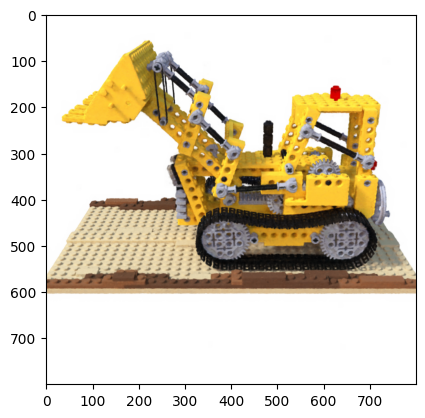

In [16]:
temp_imgs = []
for img in imgs:
    img = img.reshape(dataset.H, dataset.W, 3).detach().cpu().numpy()
    img = (img * 255).astype(np.uint8)
    temp_imgs.append(img)

imgs = temp_imgs
print(len(imgs))
print(imgs[0].shape)
plt.imshow(imgs[0])


In [19]:
import imageio

f = '/kaggle/working/video.mp4'
writer = imageio.get_writer(f, fps=10)
for img in imgs:
  writer.append_data(img)
writer.close()

from IPython.display import Video
Video(f, height=320)

In [20]:
from IPython.display import HTML
from base64 import b64encode

# Path to your video
video_path = '/kaggle/working/video.mp4'

# Read video and encode it to base64 for embedding
with open(video_path, 'rb') as f:
    video_encoded = b64encode(f.read()).decode('ascii')

# Create an HTML video player
HTML(f"""
<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
    Your browser does not support the video tag.
</video>
""")

# VALIDATION

100%|██████████| 100/100 [00:09<00:00, 10.49it/s]


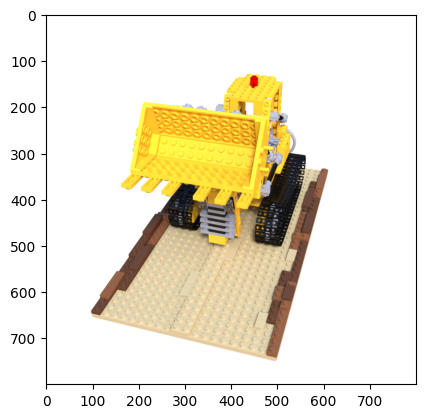

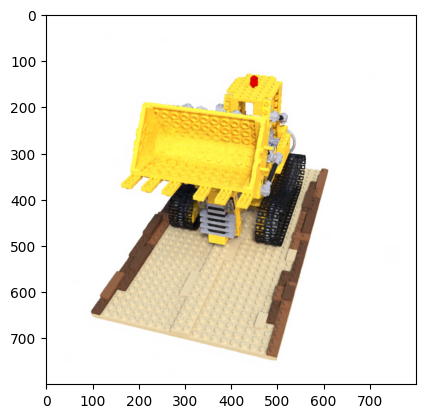

Mean PSNR:31.83623327305207


In [22]:
valset = NeRFDataset(opt, device, type='val')
poses = valset.poses
gt_imgs = valset.images
imgs = []
model.eval()
with torch.cuda.amp.autocast(enabled=trainer.fp16):
    with torch.no_grad():
        for pose in tqdm.tqdm(poses):
            # pose = nerf_matrix_to_ngp(pose, scale=valset.scale, offset=valset.offset)
            pose = pose.unsqueeze(0)
            pose = pose.to(device)
            rays = get_rays(pose, valset.intrinsics, valset.H, valset.W, -1, None, valset.opt.patch_size)
            rays_o, rays_d = rays['rays_o'], rays['rays_d']
            out = model.render(rays_o, rays_d, staged=True,bg_color=1, perturb=False, force_all_rays=False, **vars(model.opt))
            img = out['image']
            imgs.append(img)

temp_imgs = []
for img in imgs:
    img = img.reshape(dataset.H, dataset.W, 3).detach()
    temp_imgs.append(img)


imgs = temp_imgs

psnr = 0
for i in range(len(gt_imgs)):
    image = gt_imgs[i][..., :3] * gt_imgs[i][..., 3:] + 1.0 * (1 - gt_imgs[i][..., 3:])
    if i == 1:
        t_img = (image.cpu().numpy() * 255).astype(np.uint8)
        plt.imshow(t_img)
        plt.show()
        cv2.imwrite(f"gt{i}.png", t_img)
        t_img = (imgs[i].cpu().numpy() * 255).astype(np.uint8)
        plt.imshow(t_img)
        plt.show()
        cv2.imwrite(f"pred{i}.png", t_img)
    t = torch.nn.functional.mse_loss(image, imgs[i])
    t = t.item()
    psnr = psnr + -10 * np.log10(t)

mean_psnr = psnr / len(imgs)
print(f"Mean PSNR:{mean_psnr}")